In [1]:
import os
import pandas as pd
import numpy as np
import time
import cv2
import tensorflow as tf
import keras.backend as K
import keras
from tensorflow.keras import layers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
##from tensorflow.keras.utils import multi_gpu_model

from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,recall_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from tensorflow.keras import datasets, layers, models
from keras.layers import Activation, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

import pickle
from sklearn.preprocessing import StandardScaler
import joblib
from joblib import dump, load

# Data Preprocessing

In [3]:
def preprocessing_data():
    data_path="../dataset/"
    file = "label.csv"
    data=pd.read_csv(data_path+file)
    file_names=list(data['file_name'])
    labels=data['label'].values.reshape(-1,1)
    
    ohe = OneHotEncoder(handle_unknown = "ignore", sparse=False)
    ohe = ohe.fit(labels)
    labels = ohe.transform(labels)

    dump(ohe, './Task_B_one-hot encoder.joblib') 
    
    dataset_tumor=[]

    for file_index in range(len(file_names)):
        file=cv2.imread(data_path+"/image/"+file_names[file_index])
        file_resize=cv2.resize(file,(128,128))/255.
        dataset_tumor.append(file_resize)
        
    tumor_data = np.array(dataset_tumor)
    
    return tumor_data, labels

def generate_training_set():
    tumor_data, labels = preprocessing_data()
    x_train,x_test,y_train,y_test = train_test_split(tumor_data,labels,test_size=0.2)

    return x_train, x_test, y_train, y_test

In [4]:
x_train, x_test, y_train, y_test= generate_training_set()

# Training and Validation

In [5]:
def CNN():
    initial_layer=keras.Input(shape=(128,128,3),name="image")

    x1=layers.Conv2D(64,(22,22),strides=2)(initial_layer)
    x1=layers.MaxPooling2D((4,4))(x1)
    x1=layers.BatchNormalization()(x1)

    x2=layers.Conv2D(128,(11,11),strides=2,padding="same")(x1)
    x2=layers.MaxPooling2D((2,2))(x2)
    x2=layers.BatchNormalization()(x2)

    x3=layers.Conv2D(256,(7,7),strides=2,padding="same")(x2)
    x3=layers.MaxPooling2D((2,2))(x3)
    x3=layers.BatchNormalization()(x3)

    x4=layers.Flatten()(x3)
    x4=layers.Activation("relu")(x4)

    x5=layers.Dense(1024,"relu")(x4)

    x6=layers.Dense(256,"relu")(x5)

    xfinal=layers.Dense(4)(x6)
    pred=layers.Activation("softmax")(xfinal)

    model=keras.Model(inputs=initial_layer,outputs=pred)

    model.compile(loss="categorical_crossentropy",optimizer="sgd",  metrics=['mae', 'categorical_accuracy'])
    model.fit(x_train,y_train,epochs=20,batch_size=32,shuffle=False)
    model.save('./Task_B_CNN_Model')
    
    return model

In [6]:
model = CNN()

Epoch 1/20
75/75 [==============================] - 5s 17ms/step - loss: 0.8812 - mae: 0.2576 - categorical_accuracy: 0.6562
Epoch 2/20
75/75 [==============================] - 1s 17ms/step - loss: 0.5117 - mae: 0.1640 - categorical_accuracy: 0.8296
Epoch 3/20
75/75 [==============================] - 1s 16ms/step - loss: 0.2715 - mae: 0.0967 - categorical_accuracy: 0.9304
Epoch 4/20
75/75 [==============================] - 1s 17ms/step - loss: 0.1117 - mae: 0.0456 - categorical_accuracy: 0.9871
Epoch 5/20
75/75 [==============================] - 1s 16ms/step - loss: 0.0467 - mae: 0.0206 - categorical_accuracy: 0.9967
Epoch 6/20
75/75 [==============================] - 1s 18ms/step - loss: 0.0229 - mae: 0.0105 - categorical_accuracy: 0.9983
Epoch 7/20
75/75 [==============================] - 1s 19ms/step - loss: 0.0149 - mae: 0.0068 - categorical_accuracy: 0.9983
Epoch 8/20
75/75 [==============================] - 1s 17ms/step - loss: 0.0099 - mae: 0.0047 - categorical_accuracy: 0.9996


# Testing (using splitted sample data)

In [7]:
def test_model(x_test, y_test):
    loaded_model = keras.models.load_model('./Task_B_CNN_Model')
    result=loaded_model.predict(x_test)
    result_class = np.argmax(result, axis=1)
    y_test_class = np.argmax(y_test, axis=1)
    acc = sklearn.metrics.accuracy_score(result_class, y_test_class)
    print("Accuracy for test data:", acc)
    plt.figure(figsize = (5,5))
    ConfusionMatrixDisplay.from_predictions(y_test_class, result_class, cmap = 'Blues')
    plt.show()

Accuracy for test data: 0.9216666666666666


<Figure size 360x360 with 0 Axes>

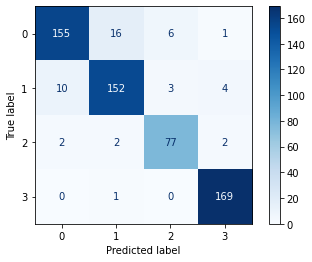

In [8]:
test_model(x_test, y_test)

# Testing (generalized with visualization)

In [9]:
## make function to graphically show result and label with plot
def test_picture(index):
    test_dataset_tumor=[]
    test_true_labels = []
    test_images = []
    
    data_path = "../dataset/"
    file = "label.csv"

    
    data=pd.read_csv(data_path+file)
    rows = len(index)
    index = ["%04d" % x for x in index]


    for i in index:
        file_name = "IMAGE_"+i+".jpg"
        file = cv2.imread(data_path+"image/"+file_name)
        file_resize = cv2.resize(file,(128,128))/255.
        
        plt.figure()
        plt.title(file_name)
        plt.imshow(file_resize)
        true_label = data["label"].loc[data['file_name'] == file_name].values.reshape(-1,1)
  
        ohe = joblib.load('./Task_B_one-hot encoder.joblib')
        true_label = ohe.transform(true_label)
        
        test_images.append(file_name)
        test_true_labels.append(true_label[0])
        test_dataset_tumor.append(file_resize)
    
    test_tumor_data = np.array(test_dataset_tumor)
    
    loaded_model = keras.models.load_model('./Task_B_CNN_Model')
    pred_labels = loaded_model.predict(test_tumor_data)
    pred_labels = tf.one_hot(np.argmax(pred_labels, axis=1), depth = 4)
    y_test_class = np.argmax(y_test, axis=1)
    
    test_true_labels = ohe.inverse_transform(test_true_labels)
    pred_labels = ohe.inverse_transform(pred_labels)
    
    for j in range(rows):
        print("Image: "+ test_images[j] +" ,True label: " + str(test_true_labels[j]) + ", Predicted label: " + str(pred_labels[j]))

Image: IMAGE_0000.jpg ,True label: ['meningioma_tumor'], Predicted label: ['meningioma_tumor']


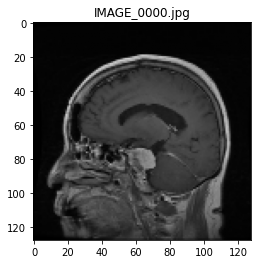

In [10]:
test_picture([0])